In [73]:
import pandas as pd
import seaborn as sb
import joblib
import matplotlib.pyplot as plt
import truvari
import pysam
import joblib
from truvari.annotations.lcr import sequence_entropy

In [74]:
maybe = joblib.load("maybe_not_TR.jl")
prob = joblib.load("probably_TR.jl")

In [75]:
def make_seq_lookup(vcf_fn):
    v = pysam.VariantFile(vcf_fn)
    ret = {}
    for entry in v:
        s, e = truvari.entry_boundaries(entry)
        key = entry.chrom + ":" + str(s) + '-' + str(e)
        if len(entry.ref) > len(entry.alts[0]):
            seq = entry.ref[1:]
            entropy = sequence_entropy(entry.ref[1:])
        else:
            seq = entry.alts[0][1:]
            entropy = sequence_entropy(entry.alts[0][1:])
        ret[key] = [seq, entropy]
    return ret
m_seqs = make_seq_lookup("maybe_not_TR.vcf.gz")11212
p_seqs = make_seq_lookup("probably_TR.vcf.gz")

In [76]:
maybe['TRFrepeat'].isna().sum(), len(maybe)

(47, 169)

In [77]:
prob['TRFrepeat'].isna().sum(), len(prob)

(0, 1561)

In [78]:
maybe['key'] = maybe.apply((lambda x: f"{x['chrom']}:{x['start']}-{x['end']}"), axis=1)
prob['key'] = prob.apply((lambda x: f"{x['chrom']}:{x['start']}-{x['end']}"), axis=1)
maybe['seq'] = maybe['key'].apply(lambda x: m_seqs.get(x)[0])
prob['seq'] = prob['key'].apply(lambda x: p_seqs.get(x)[0])
maybe['entropy'] = maybe['key'].apply(lambda x: m_seqs.get(x)[1])
prob['entropy'] = prob['key'].apply(lambda x: p_seqs.get(x)[1])

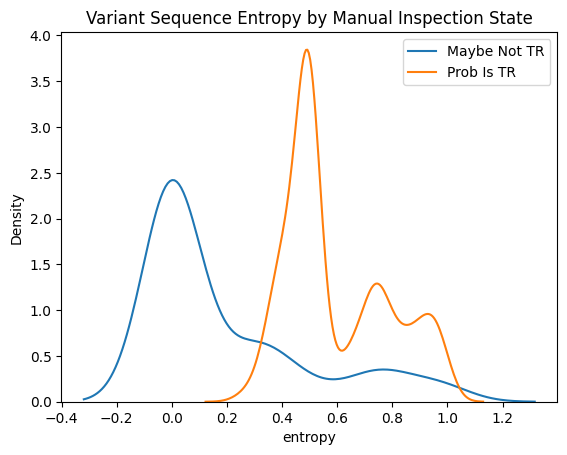

In [157]:
sb.kdeplot(maybe['entropy'], label="Maybe Not TR")
p = sb.kdeplot(prob['entropy'], label="Prob Is TR")
p.set(title="Variant Sequence Entropy by Manual Inspection State")
plt.legend()


In [97]:
maybe['low_entropy'] = maybe['entropy'] < 0.25
maybe['is_period_1'] = maybe['TRFperiod'].apply(lambda x: x is not None and x == 1)

prob['low_entropy'] = prob['entropy'] < 0.25
prob['is_period_1'] = prob['TRFperiod'].apply(lambda x: x is not None and x == 1)

In [98]:
maybe.groupby(['low_entropy', 'is_period_1']).size().unstack()

is_period_1,False,True
low_entropy,,
False,44,8
True,76,41


In [82]:
prob.groupby(['low_entropy', 'is_period_1']).size().unstack()

is_period_1,False
low_entropy,
False,1561


In [84]:
maybe.columns

Index(['chrom', 'start', 'end', 'id', 'svtype', 'svlen', 'szbin', 'qual',
       'filter', 'is_pass', 'SVTYPE', 'SVLEN', 'AC', 'AN', 'NS', 'AC_Hom',
       'AC_Het', 'AC_Hemi', 'AF', 'MAF', 'HWE', 'ExcHet', 'TRF', 'TRFdiff',
       'TRFrepeat', 'TRFovl', 'TRFstart', 'TRFend', 'TRFperiod', 'TRFcopies',
       'TRFscore', 'TRFentropy', 'TRFsim', 'Mcur', 'key', 'seq', 'entropy',
       'low_entropy', 'is_period_1'],
      dtype='object')

In [100]:
need_to_find = maybe[~maybe['low_entropy'] & ~maybe['is_period_1']]
len(need_to_find)

44

In [94]:
need_to_find['Mcur'].value_counts()

not_annotated    25
not_in_annos     19
Name: Mcur, dtype: int64

In [101]:
prob['Mcur'].value_counts()

annotated       1391
not_in_annos     170
Name: Mcur, dtype: int64

In [102]:
# if "TRFdiff" not in entry.info or entry.info["TRFdiff"] == None:
need_to_find = maybe[~maybe['low_entropy'] & ~maybe['is_period_1'] & (maybe['Mcur'] != 'not_annotated')]
len(need_to_find)

19

In [ ]:
# so my heuristics are:
#      Remove period=1
#      entropy of changed seq is < 0.25
#      "TRFdiff" not in entry.info or entry.info["TRFdiff"] == None

In [147]:
import pysam
from truvari.annotations.lcr import sequence_entropy
def filter_TR_entry(entry):
    """
    Returns True if this should be filtered
    """
    if "TRFdiff" not in entry.info or entry.info["TRFdiff"] == None:
        return True
    if entry.info["TRFperiod"] == 1:
        return True
    if len(entry.alts[0]) > len(entry.ref):
        seq = entry.alts[0][1:]
    else:
        seq = entry.ref[1:]
    if sequence_entropy(seq) < 0.25:
        return True
    return False


In [150]:
from collections import Counter

v = pysam.VariantFile("probably_TR.vcf.gz")
cnts = Counter()
for entry in v:
    state = filter_TR_entry(entry)
    cnts[filter_TR_entry(entry)] += 1
print(cnts)

Counter({False: 1561})


In [151]:
from collections import Counter

v = pysam.VariantFile("maybe_not_TR.vcf.gz")
cnts = Counter()
for entry in v:
    state = filter_TR_entry(entry)
    if not state:
        print(entry)
    cnts[filter_TR_entry(entry)] += 1
print(cnts)

Counter({True: 150})


In [153]:
from collections import Counter

v = pysam.VariantFile("heuristics_fp_TR.vcf.gz")
cnts = Counter()
for entry in v:
    state = filter_TR_entry(entry)
    cnts[filter_TR_entry(entry)] += 1
print(cnts)

Counter({False: 19})


[E::idx_find_and_load] Could not retrieve index file for 'heuristics_fp_TR.vcf.gz'


So I have heuristics on if I think different variants are TR expansions/contractions.

There are 1561 TP - variants we identified as TRs and I think probably are TRs.
There are 150 TN - where I think they aren't TRs and we're not identifying them as TRs.
There are 19 FP - where I don't think they are TRs, but our heuristics are saying they are.

Assuming I've correctly separated these out, this would put the precision at 98.8%.
And our False Positive Rate at: # fp / (fp+tn) at 11.2%, though I do think 6 might not be FPs which would put FPR at 8%




In [154]:
data = joblib.load("green.jl")

<AxesSubplot: xlabel='is_anno', ylabel='count'>

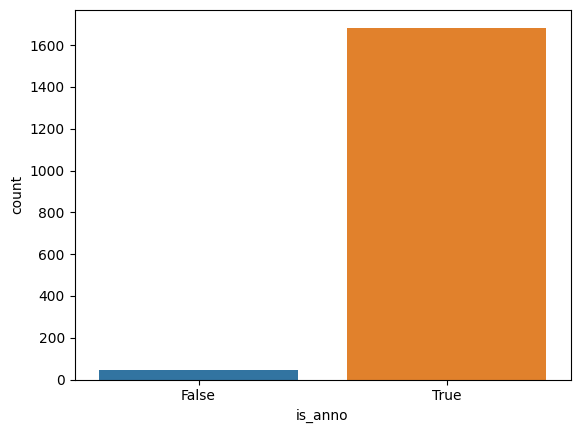

In [155]:
data['is_anno'] = ~data['TRFdiff'].isna()
sb.countplot(data=data[data['svlen'] >= 5], x="is_anno")

<AxesSubplot: xlabel='is_period', ylabel='count'>

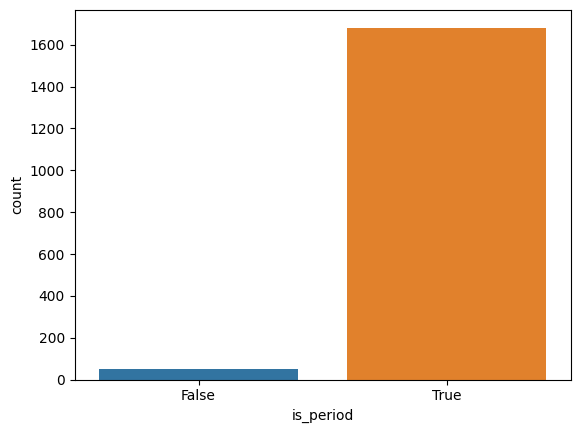

In [156]:
data['is_period'] = data['TRFperiod'] != 1
sb.countplot(data=data[data['svlen'] >= 5], x="is_period")

In [159]:
data[data['svlen'] >= 5]['filter'].value_counts()

[PASS]     1581
[NONTR]     150
Name: filter, dtype: int64